#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold, TimeSeriesSplit
from sklearn.metrics import mean_squared_error as mse

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])   

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [6]:
df.isna().sum()

num_orders    0
dtype: int64

Данные готовы для работы.

## Анализ

Для дальнейшей работы нам требуется произвести ресемплинг.

In [11]:
data = df.resample("1H").sum()
data.sort_index(inplace=True)
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


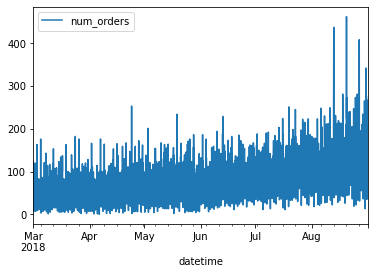

In [8]:
data.plot();

Подготовим скользащее среднее, чтобы иметь данные которые меньше всего подвержены колебаниям.

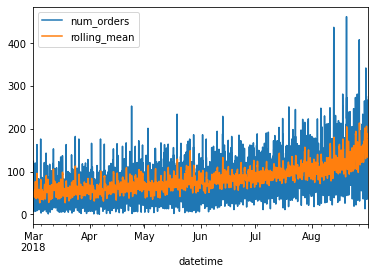

In [9]:
data['rolling_mean'] = data.rolling(10).mean()
data.plot();

Применим функцию seasonal_decompose(), чтобы разложить данные на тренд, сезонность и остаток:

In [12]:
decomposed = seasonal_decompose(data)

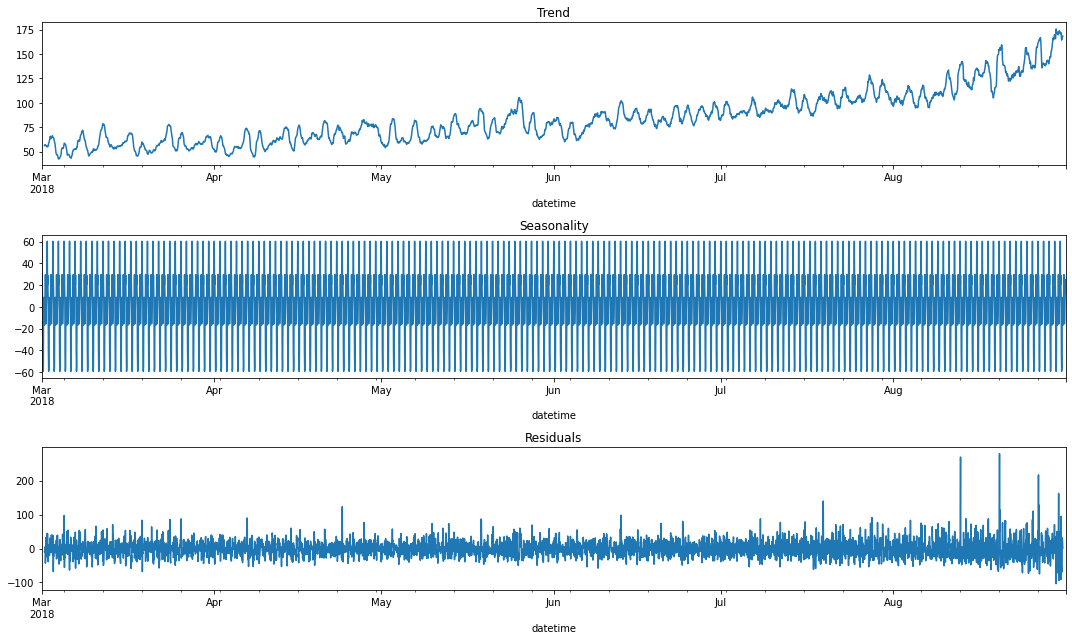

In [13]:
plt.figure(figsize=(15, 9))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наблюдается тренд на увеличение числа заказов, график сезонности на таком масштабе не информативен. Посмотрим на сезонность в приделах двух случайных суток:

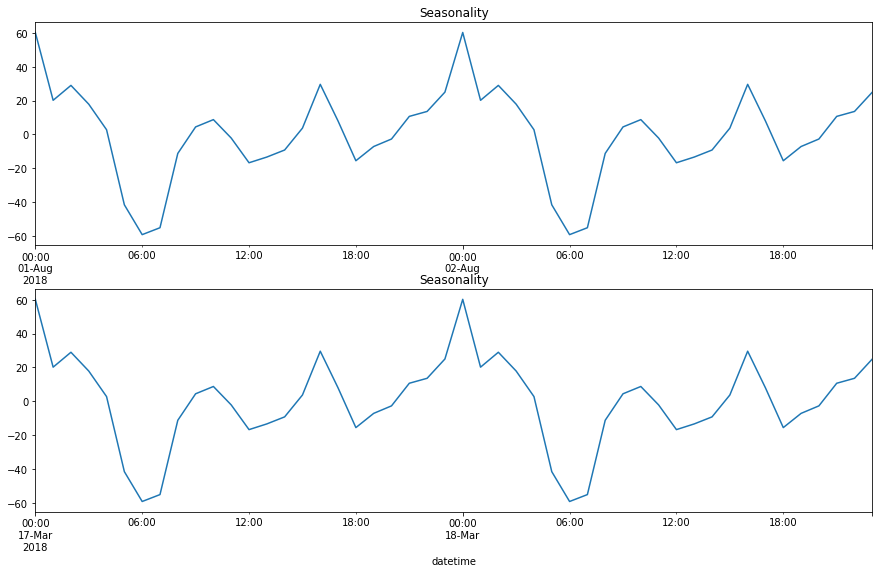

In [14]:
plt.figure(figsize=(15, 9))
plt.subplot(211)
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(212)
decomposed.seasonal['2018-03-17':'2018-03-18'].plot(ax=plt.gca())
plt.title('Seasonality');

Ночью колличество заказов больше, но к 6 утра падает до минимума, а после постепенно растет.

## Обучение

Подготовим необходимые признаки и метрики. И обучим разные модели.

In [15]:
def rmse(y, a):
    return mse(y, a)**0.5

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()


In [17]:
make_features(data, 4, 10)

In [18]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### CatBoost

In [19]:
%%time
tscv = TimeSeriesSplit()
parametrs = {
                 'depth' : [i for i in range(1, 10, 2)],
                }

model_grid = CatBoostRegressor(iterations=500,  verbose=100)
grid = GridSearchCV(estimator=model_grid, param_grid=parametrs, cv=tscv, n_jobs=-1)
grid.fit(features_train, target_train)

print(f'Лучшие параметры модели:{grid.best_params_}')

Learning rate set to 0.089417
0:	learn: 37.0913190	total: 136ms	remaining: 1m 7s
100:	learn: 20.9513297	total: 402ms	remaining: 1.59s
200:	learn: 18.1443869	total: 672ms	remaining: 999ms
300:	learn: 16.4476544	total: 928ms	remaining: 614ms
400:	learn: 15.1358756	total: 1.19s	remaining: 294ms
499:	learn: 13.9562426	total: 1.46s	remaining: 0us
Лучшие параметры модели:{'depth': 7}
Wall time: 26.7 s


In [20]:
%%time
model_cat = CatBoostRegressor(iterations=500, depth=7, verbose=100)
model_cat.fit(features_train, target_train)
model_cat_train_predict = model_cat.predict(features_train)

print(f'RMSE CatBost на тренировочной выборке: {rmse(target_train, model_cat_train_predict)}')

Learning rate set to 0.089417
0:	learn: 37.0913190	total: 2.87ms	remaining: 1.43s
100:	learn: 20.9513297	total: 269ms	remaining: 1.06s
200:	learn: 18.1443869	total: 536ms	remaining: 797ms
300:	learn: 16.4476544	total: 796ms	remaining: 526ms
400:	learn: 15.1358756	total: 1.09s	remaining: 270ms
499:	learn: 13.9562426	total: 1.35s	remaining: 0us
RMSE CatBost на тренировочной выборке: 13.95624258531973
Wall time: 1.49 s


### LightGBM

In [21]:
%%time

model_lgbm = LGBMRegressor(silent=True)
model_lgbm.fit(features_train, target_train)
model_lgbm_pred = model_lgbm.predict(features_train)

print(f'RMSE LightGBM на тренировочной выборке: {rmse(target_train, model_lgbm_pred)}')

RMSE LightGBM на тренировочной выборке: 16.198961806556344
Wall time: 134 ms


### LinearRegression

In [22]:
%%time

model_lr = LinearRegression()
model_lr.fit(features_train, target_train)
model_lr_train_pred = model_lr.predict(features_train)

print(f'RMSE LinearRegression на тренировочной выборке: {rmse(target_train, model_lr_train_pred)}')

RMSE LinearRegression на тренировочной выборке: 31.36516039937285
Wall time: 18 ms


### Ridge

In [23]:
%%time

model_ridge = Ridge()
model_ridge.fit(features_train, target_train)
model_ridge_train_pred = model_ridge.predict(features_train)

print(f'RMSE Ridge на тренировочной выборке: {rmse(target_train, model_ridge_train_pred)}')

RMSE Ridge на тренировочной выборке: 31.365160399384866
Wall time: 11 ms


### Lasso

In [24]:
%%time

model_lasso = Lasso()
model_lasso.fit(features_train, target_train)
model_lasso_train_pred = model_lasso.predict(features_train)

print(f'RMSE Lasso на тренировочной выборке: {rmse(target_train, model_lasso_train_pred)}')

RMSE Lasso на тренировочной выборке: 31.367109639902875
Wall time: 12 ms


Лучше всего показали себя модели с бустингом.

## Тестирование

### CatBoost

In [25]:
model_cat_test_predict = model_cat.predict(features_test)

print(f'RMSE CatBost на тестовой выборке: {rmse(target_test, model_cat_test_predict)}')

RMSE CatBost на тестовой выборке: 46.9256177523506


### LightGBM

In [26]:
model_lgbm_test_pred = model_lgbm.predict(features_test)

print(f'RMSE LightGBM на тренировочной выборке: {rmse(target_test, model_lgbm_test_pred)}')

RMSE LightGBM на тренировочной выборке: 45.92238491052299


### LinearRegression

In [27]:
model_lr_test_pred = model_lr.predict(features_test)

print(f'RMSE LinearRegression на тестовой выборке: {rmse(target_test, model_lr_test_pred)}')

RMSE LinearRegression на тестовой выборке: 53.5944221218886


### Ridge

In [28]:
model_ridge_test_pred = model_ridge.predict(features_test)

print(f'RMSE Ridge на тестовой выборке: {rmse(target_test, model_ridge_test_pred)}')

RMSE Ridge на тестовой выборке: 53.59442725080321


### Lasso

In [29]:
model_lasso_test_pred = model_lasso.predict(features_test)

print(f'RMSE Lasso на тестовой выборке: {rmse(target_test, model_lasso_test_pred)}')

RMSE Lasso на тестовой выборке: 53.650654219594706


In [30]:
print(f'RMSE CatBost на тестовой выборке:          {rmse(target_test, model_cat_test_predict)}',
      f'\nRMSE LightGBM на тренировочной выборке:    {rmse(target_test, model_lgbm_test_pred)}',
      f'\nRMSE LinearRegression на тестовой выборке: {rmse(target_test, model_lr_test_pred)}',
      f'\nRMSE Ridge на тестовой выборке:            {rmse(target_test, model_ridge_test_pred)}',
      f'\nRMSE Lasso на тестовой выборке:            {rmse(target_test, model_lasso_test_pred)}')

RMSE CatBost на тестовой выборке:          46.9256177523506 
RMSE LightGBM на тренировочной выборке:    45.92238491052299 
RMSE LinearRegression на тестовой выборке: 53.5944221218886 
RMSE Ridge на тестовой выборке:            53.59442725080321 
RMSE Lasso на тестовой выборке:            53.650654219594706


RMSE LightGBM на тренировочной выборке: 45.92238491052299 
Графики исходного и предсказанного рядов:


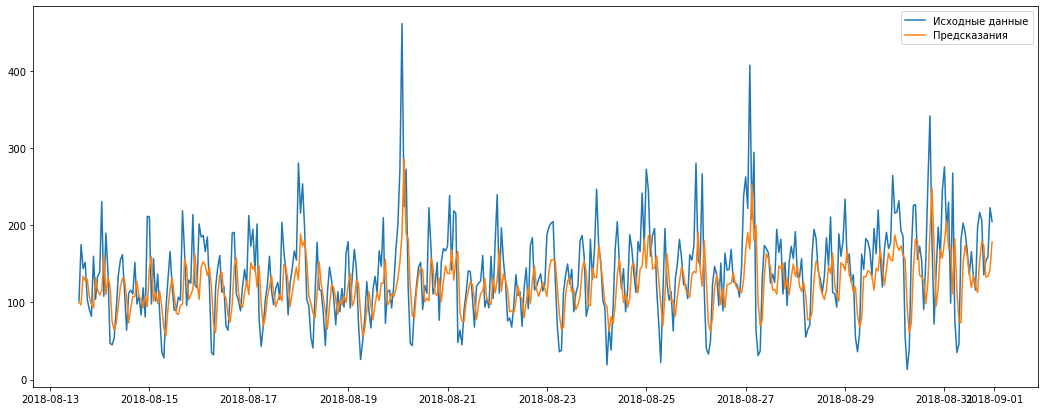

In [31]:
print(f'RMSE LightGBM на тренировочной выборке: {rmse(target_test, model_lgbm_test_pred)}',
     f'\nГрафики исходного и предсказанного рядов:')
plt.figure(figsize=(18, 7))
plt.plot(features_test.index, target_test, label='Исходные данные')
plt.plot(features_test.index, model_lr_test_pred, label='Предсказания')
plt.legend()
plt.show()

На тестовой выборке модели с бустингом так же показали лучшие результаты.

## Выводы

Лучше всего показала себя модель LightGBM со значением RMSE 45.92, значение RMSE CatBost чуть хуже 46.92. Модели LinearRegression, Ridge и Lasso показали себя хуже всего среднее RMSE 53.6 на тестовой выборке все три модели.

Исходя из выводов сделанных выше, рекомендовать заказчику можно модель LightGBM, как показавшую наилучшую метрику качества для данной выборки.

В ходе выполнения поставленной задачи удалось выполнить следующие шаги:

* Выполнен анализ и обработка полученных от заказчика данных;
* Обучены 2 модели с бустингом и 3 без бустинга;
* проведен анализ и подготовлены рекомендации для заказчика.